In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import cv2 as cv
import pandas as pd
from scipy.stats import kurtosis, skew
from tqdm.notebook import tqdm

from ml_projects.posh.utils import data, fluorescence,microscope
from ml_projects.microscopy_common.utils import plate


from insitro_data.utils import db_utils
from ml_projects.posh.utils import image as image_utils
from skimage import measure,exposure, color


In [2]:
plate_id = "PC2088"
channel_map = {"DAPI": 3, 
               "WGA_488": 2,
               "WGA_555": 1,
               "Lysoview_630": 0}

channel_map_tech_dev = {"DAPI": 1, 
               "WGA_488": 2,
               "WGA_555": 0,
               "Lysoview_630": 0}

well_map = {
            "DAPI" : ['A01','B01'],
            "DAPI+WGA488" : ['A02','B02'],
            "DAPI+WGA55" : ['A03','B03'],
            "DAPI+Lysoview633" : ['A04','B04'],
              
            "DAPI+WGA488+WGA55": ['C01','D01'],
            "DAPI+WGA488+Lysoview633": ['C02','D02'],
            "DAPI+WGA55+Lysoview633": ['C03','D03'],
            "DAPI+WGA55+WGA55+Lysoview633": ['C04','D04']
}

#sql query : note that is is based on the plate map
query = (
    f"select * from canonical_image where plate_barcode = 'PC2088' AND microscope_id = 6")

In [3]:
def normalize(raw_image:np.ndarray):
    '''
    Function that normalises the image
    input : single channel 2D image
    '''
    image = cv.normalize(
        raw_image, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F
    )
    return image


def vis_channel_wise(img,cmap):
    fig = plt.figure(figsize=(8, 8),dpi=300)
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    ax1.imshow(img[cmap["DAPI"]],cmap ="gray")
    ax1.title.set_text("DAPI")
    ax1.axis('off')
    ax2.imshow(img[cmap["WGA_488"]],cmap ="gray")
    ax2.title.set_text("WGA_488")
    ax2.axis('off')
    ax3.imshow(img[cmap["WGA_555"]],cmap ="gray")
    ax3.title.set_text("WGA_555")
    ax3.axis('off')
    ax4.imshow(img[cmap["Lysoview_630"]],cmap ="gray")
    ax4.title.set_text("Lysoview_630")
    ax4.axis('off')
    fig.show()
    
def channel_features(img):
    
    feat ={ "sum": float(np.sum(img.ravel())),
            "mean": float(np.mean(img.ravel())),
            "min": float(np.min(img.ravel())),
            "max": float(np.max(img.ravel())),
            "sd": float(np.std(img.ravel())),
            "kurtosis": float(kurtosis(img.ravel())),
            "skew" : float(skew(img.ravel()))
          }
    
    return pd.DataFrame([feat])

def plot_heatmap(mat):
        
    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
    im = ax.imshow(mat, cmap='coolwarm', interpolation='nearest')

    ax.set_xticks(np.arange(mat.shape[1]), labels = list(mat.columns))
    ax.set_yticks(np.arange(mat.shape[0]), labels = list(mat.index))


    # Loop over data dimensions and create text annotations.
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            text = ax.text(j, i, mat.iloc[i, j],
                           ha="center", va="center", color="w")


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    fig.tight_layout()
    plt.show()


In [4]:
## obtain the s3 database
plates = data.get_nikon_plates()
## Obtain the most recent acquisition 
measurement_id = plates[(plates.plate_id == plate_id)].sort_values(by=['acquisition_time'],ascending=False).iloc[0]["uuid"]
acquisition_df = data.create_acquisition_dataframe(measurement_id)

#connect to the sql database and extract the experiment info
engine = db_utils.get_readonly_research_db_engine()
con = engine.connect()
techdev_scope = pd.read_sql(query, con)
techdev_acquisition = data.create_multi_acquisition_canonical_dataframe(list(techdev_scope.measurement_id.unique()))

INFO:root:Selected Acquisition Folders: 
 ['nikon3/Nikon_Confocal_DB2 Projects/PC2088/Spectra_20X_WF/20220812_164654_445']


In [5]:
# For each condition open a random image and visualise each plate by its channels
nikon_features = pd.DataFrame()

for sample in list(well_map.keys())[0:2]:
    print(sample)
    for i in (range(5)):
        well = np.random.choice(well_map[sample])
        image_path = np.random.choice(acquisition_df[acquisition_df.well_loc == well ].path)
        #open image
        image = data.read_image(image_path)
        #visualise each image across channels
        vis_channel_wise(image,channel_map)

        feat = pd.concat([channel_features(image[channel_map["DAPI"]]).add_prefix('DAPI_').reset_index(drop=True),
                        channel_features(image[channel_map["WGA_488"]]).add_prefix('WGA_488_').reset_index(drop=True),
                       channel_features(image[channel_map["WGA_555"]]).add_prefix('WGA_555_').reset_index(drop=True),
                       channel_features(image[channel_map["Lysoview_630"]]).add_prefix('Lysoview_630_')],
                  axis = 1)
        feat["sample"] = sample

        nikon_features = pd.concat([feat,nikon_features], ignore_index = True)



DAPI
DAPI+WGA488
DAPI+WGA55
DAPI+Lysoview633
DAPI+WGA488+WGA55
DAPI+WGA488+Lysoview633
DAPI+WGA55+Lysoview633
DAPI+WGA55+WGA55+Lysoview633


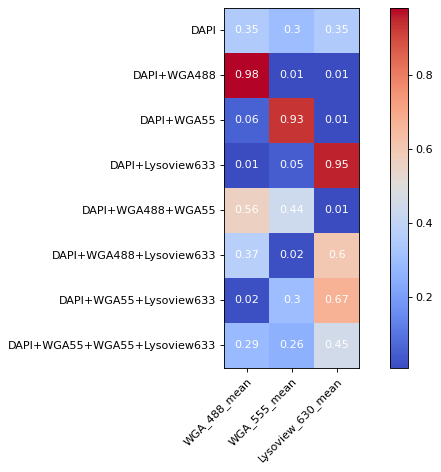

In [6]:
feature = '_mean'

avg_features = nikon_features.groupby("sample")
cols_to_select = [sub + feature for sub in list(channel_map.keys())[1:4]]

mat = np.array([np.array(avg_features.get_group(list(well_map.keys())[0])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[1])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[2])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[3])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[4])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[5])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[6])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[7])[cols_to_select].agg('mean')), 
     ], np.int32)

features = cols_to_select
samples = list(well_map.keys())
matrix = pd.DataFrame(mat, columns=features, index= samples)
normalised_matrix = (matrix.T/list(np.sum(matrix,axis = 1))).T

plot_heatmap(normalised_matrix.round(2))

DAPI
DAPI+WGA488


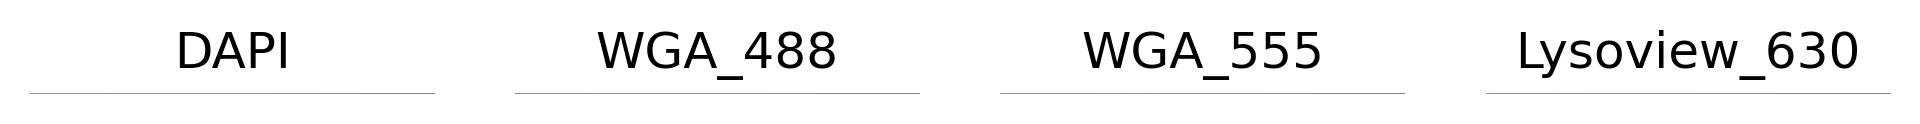

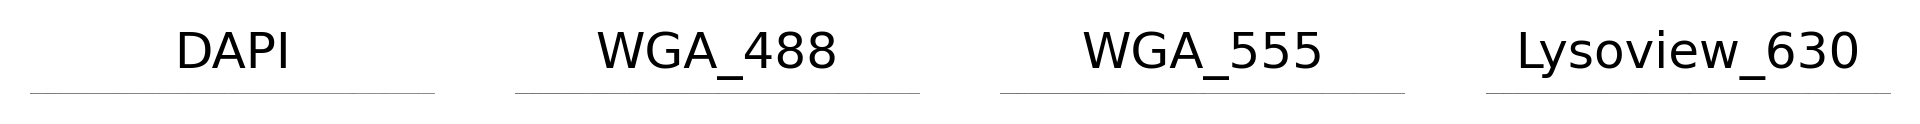

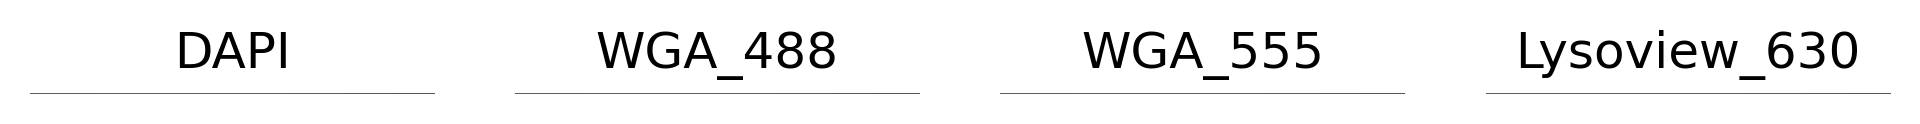

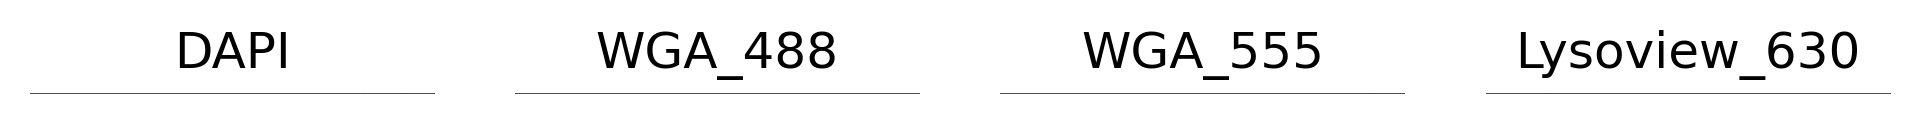

In [18]:
# For each condition open a random image and visualise each plate by its channels
techdev_features = pd.DataFrame()

for sample in list(well_map.keys())[0:2]:
    print(sample)
    for i in (range(2)):
        well = np.random.choice(well_map[sample])
        image_path = np.random.choice(techdev_acquisition[techdev_acquisition.well_loc == well ].file_path)
        #open image
        image = data.read_image(image_path)
        #visualise each image across channels
        vis_channel_wise(image,channel_map)

        feat = pd.concat([channel_features(image[channel_map["DAPI"]]).add_prefix('DAPI_').reset_index(drop=True),
                        channel_features(image[channel_map["WGA_488"]]).add_prefix('WGA_488_').reset_index(drop=True),
                       channel_features(image[channel_map["WGA_555"]]).add_prefix('WGA_555_').reset_index(drop=True),
                       channel_features(image[channel_map["Lysoview_630"]]).add_prefix('Lysoview_630_')],
                  axis = 1)
        feat["sample"] = sample

        techdev_features = pd.concat([feat,techdev_features], ignore_index = True)



In [17]:
avg_features.get_group(list(well_map.keys())[0])

,DAPI_sum,DAPI_mean,DAPI_min,DAPI_max,DAPI_sd,DAPI_kurtosis,DAPI_skew,WGA_488_sum,WGA_488_mean,WGA_488_min,...,WGA_555_kurtosis,WGA_555_skew,Lysoview_630_sum,Lysoview_630_mean,Lysoview_630_min,Lysoview_630_max,Lysoview_630_sd,Lysoview_630_kurtosis,Lysoview_630_skew,sample
350,259403143.0,14073.521213,88.0,38381.0,14589.424244,-1.624461,0.277126,259367908.0,14071.609592,83.0,...,-1.625443,0.276535,259165286.0,14060.616645,76.0,38284.0,14580.636408,-1.624664,0.277034,DAPI
351,216195421.0,11729.352268,87.0,44606.0,13336.237638,-0.976920,0.684850,216139064.0,11726.294705,86.0,...,-0.979097,0.684033,215899733.0,11713.310167,63.0,42087.0,13328.256569,-0.975855,0.685805,DAPI
352,245351658.0,13311.179362,78.0,38411.0,13924.701944,-1.520264,0.332207,245287899.0,13307.720215,74.0,...,-1.520801,0.331999,245131529.0,13299.236599,80.0,38056.0,13916.425401,-1.520647,0.331999,DAPI
353,203589816.0,11045.454427,83.0,36791.0,12358.553821,-1.156893,0.644233,203470737.0,11038.993978,80.0,...,-1.157706,0.644248,203476145.0,11039.287381,82.0,35212.0,12356.904710,-1.157665,0.644440,DAPI
354,213399582.0,11577.668294,85.0,36709.0,12900.943901,-1.143524,0.602788,213287706.0,11571.598633,84.0,...,-1.142650,0.603430,213258578.0,11570.018338,78.0,36648.0,12900.629787,-1.141771,0.603773,DAPI
355,262279120.0,14229.552951,90.0,44926.0,14685.524857,-1.629810,0.264591,262287766.0,14230.022027,82.0,...,-1.629264,0.265027,262111707.0,14220.470215,75.0,44424.0,14681.036971,-1.630699,0.264428,DAPI
356,189956595.0,10305.804850,90.0,36703.0,11816.793685,-0.974126,0.730220,189963913.0,10306.201877,68.0,...,-0.974875,0.729879,189899727.0,10302.719564,79.0,36070.0,11809.613649,-0.974344,0.729890,DAPI
357,214851456.0,11656.437500,81.0,38273.0,12759.174110,-1.193262,0.568446,214802030.0,11653.755968,68.0,...,-1.187201,0.571345,214678934.0,11647.077582,83.0,39674.0,12762.006194,-1.185490,0.572377,DAPI
358,209162102.0,11347.770291,80.0,34669.0,12175.482655,-1.228223,0.571913,208889354.0,11332.972765,84.0,...,-1.228120,0.572401,208465547.0,11309.979763,81.0,34346.0,12152.594318,-1.226601,0.573840,DAPI
359,248359013.0,13474.338813,72.0,39101.0,13912.250943,-1.560662,0.321128,248374794.0,13475.194987,74.0,...,-1.562045,0.320727,248026191.0,13456.282064,76.0,39267.0,13906.766491,-1.562032,0.320942,DAPI


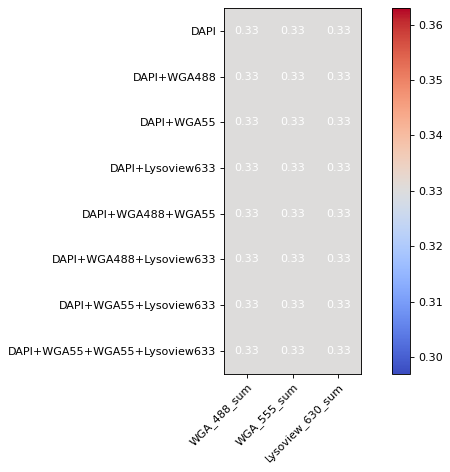

In [15]:
feature = '_sum'

avg_features = techdev_features.groupby("sample")
cols_to_select = [sub + feature for sub in list(channel_map.keys())[1:4]]

mat = np.array([np.array(avg_features.get_group(list(well_map.keys())[0])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[1])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[2])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[3])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[4])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[5])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[6])[cols_to_select].agg('mean')), 
                np.array(avg_features.get_group(list(well_map.keys())[7])[cols_to_select].agg('mean')), 
     ], np.int32)

features = cols_to_select
samples = list(well_map.keys())
matrix = pd.DataFrame(mat, columns=features, index= samples)
normalised_matrix = (matrix.T/list(np.sum(matrix,axis = 1))).T

plot_heatmap(normalised_matrix.round(2))

In [11]:
techdev_features

,DAPI_sum,DAPI_mean,DAPI_min,DAPI_max,DAPI_sd,DAPI_kurtosis,DAPI_skew,WGA_488_sum,WGA_488_mean,WGA_488_min,...,WGA_555_kurtosis,WGA_555_skew,Lysoview_630_sum,Lysoview_630_mean,Lysoview_630_min,Lysoview_630_max,Lysoview_630_sd,Lysoview_630_kurtosis,Lysoview_630_skew,sample
0,518761284.0,28144.600911,511.0,65535.0,18538.189440,-0.191770,0.492408,518612971.0,28136.554416,513.0,...,-0.191927,0.492784,518554563.0,28133.385579,500.0,65535.0,18537.736683,-0.192024,0.492904,DAPI+WGA55+WGA55+Lysoview633
1,434928664.0,23596.390191,478.0,65535.0,18570.029982,0.302497,1.016977,434852191.0,23592.241265,446.0,...,0.303050,1.017316,434585172.0,23577.754557,460.0,65535.0,18557.135231,0.301939,1.016676,DAPI+WGA55+WGA55+Lysoview633
2,489930975.0,26580.456543,469.0,65535.0,17538.748349,0.158347,0.611240,489946927.0,26581.321994,457.0,...,0.165495,0.613680,489683407.0,26567.025119,433.0,65535.0,17507.031209,0.162416,0.611898,DAPI+WGA55+WGA55+Lysoview633
3,538018254.0,29189.358398,504.0,65535.0,18278.742016,-0.099981,0.348476,537592039.0,29166.234755,491.0,...,-0.095151,0.348992,537015512.0,29134.956163,487.0,65535.0,18261.032833,-0.091358,0.350228,DAPI+WGA55+WGA55+Lysoview633
4,459671923.0,24938.797906,467.0,65535.0,18340.019120,0.127411,0.850074,459730755.0,24941.989746,476.0,...,0.118362,0.848108,459650497.0,24937.635471,459.0,65535.0,18354.999797,0.117856,0.848655,DAPI+WGA55+WGA55+Lysoview633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,275231265.0,14932.251790,80.0,42224.0,14640.679628,-1.949584,0.029300,275282030.0,14935.005968,80.0,...,-1.949262,0.029960,275388072.0,14940.759115,76.0,43061.0,14656.822861,-1.949352,0.029844,DAPI
396,277462957.0,15053.328830,72.0,39045.0,15191.928624,-1.757305,0.170274,277357996.0,15047.634332,84.0,...,-1.757258,0.170442,277114700.0,15034.434679,81.0,39175.0,15178.200446,-1.757128,0.170596,DAPI
397,275804261.0,14963.338813,88.0,39777.0,15106.768605,-1.783153,0.160865,275648705.0,14954.899360,86.0,...,-1.782232,0.161731,275430148.0,14943.041884,84.0,39073.0,15100.066642,-1.782361,0.161713,DAPI
398,248567214.0,13485.634440,84.0,39610.0,14216.993220,-1.475894,0.367299,248445697.0,13479.041721,82.0,...,-1.476887,0.366549,248260257.0,13468.980957,82.0,40163.0,14202.938470,-1.475825,0.367019,DAPI
